# DeepShot: Spatial Model

In this notebook, we'll build a spatial model to predict shot success based on court location.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Create directories
processed_dir = Path('../data/processed')
features_dir = processed_dir / 'features'
models_dir = Path('../models')
spatial_model_dir = models_dir / 'spatial_model'

for directory in [processed_dir, features_dir, models_dir, spatial_model_dir]:
    directory.mkdir(parents=True, exist_ok=True)

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.15.0
GPU available: []


## Court Visualization Function

In [3]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = patches.Rectangle((-30, -7.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box of the paint, width=16ft, height=19ft
    outer_box = patches.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    # Create the inner box of the paint, width=12ft, height=19ft
    inner_box = patches.Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)

    # Create free throw top arc
    top_free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = patches.Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = patches.Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
    corner_three_b = patches.Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)

    # Center Court
    center_outer_arc = patches.Arc((0, 422.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = patches.Arc((0, 422.5), 40, 40, theta1=180, theta2=0, linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw, bottom_free_throw, restricted, 
                      corner_three_a, corner_three_b, three_arc, center_outer_arc, center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = patches.Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

## Data Preparation

In [4]:
# Load shot data with features
shots = pd.read_csv(features_dir / 'shots_with_features.csv')
print(f"Loaded {len(shots)} shots")

# Define target variable and spatial features
target = 'shot_made'
spatial_features = ['loc_x', 'loc_y', 'shot_distance', 'shot_angle']

# Prepare data
model_data = shots[spatial_features + [target]].copy()
model_data = model_data.dropna()

# Split features and target
X = model_data.drop(target, axis=1)
y = model_data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {X_train.shape}")
print(f"Testing data: {X_test.shape}")

Loaded 4650091 shots
Training data: (3720072, 4)
Testing data: (930019, 4)


In [5]:
# Normalize spatial coordinates
def normalize_coordinates(data):
    data_norm = data.copy()
    
    # Normalize x and y coordinates
    x_min, x_max = -250, 250
    y_min, y_max = -50, 450
    data_norm['loc_x_norm'] = (data_norm['loc_x'] - x_min) / (x_max - x_min)
    data_norm['loc_y_norm'] = (data_norm['loc_y'] - y_min) / (y_max - y_min)
    
    # Normalize shot distance
    max_distance = 500  # Maximum possible distance on court
    data_norm['shot_distance_norm'] = data_norm['shot_distance'] / max_distance
    
    # Normalize shot angle
    data_norm['shot_angle_norm'] = (data_norm['shot_angle'] + 180) / 360
    
    return data_norm

# Normalize training and testing data
X_train_norm = normalize_coordinates(X_train)
X_test_norm = normalize_coordinates(X_test)

# Prepare input data for CNN
feature_cols = ['loc_x_norm', 'loc_y_norm', 'shot_distance_norm', 'shot_angle_norm']
X_train_cnn = X_train_norm[feature_cols].values
X_test_cnn = X_test_norm[feature_cols].values

print(f"CNN input shape: {X_train_cnn.shape}")

CNN input shape: (3720072, 4)


## Visualize Shot Distribution

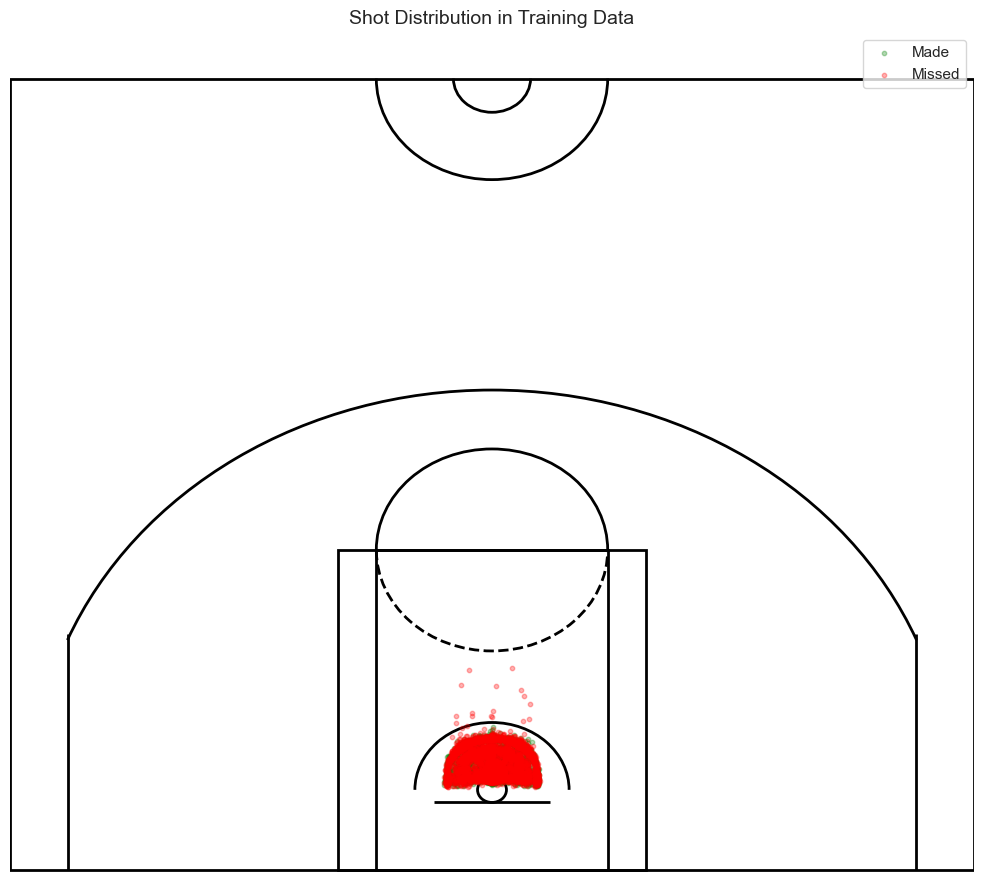

In [6]:
# Create a sample of shots for visualization
sample_size = min(10000, len(X_train))
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Plot shot distribution
plt.figure(figsize=(10, 9))
ax = plt.gca()
draw_court(ax, outer_lines=True)

# Plot shots (made shots in green, missed in red)
made_shots = X_train_sample[y_train_sample == 1]
missed_shots = X_train_sample[y_train_sample == 0]

plt.scatter(made_shots['loc_x'], made_shots['loc_y'], c='green', alpha=0.3, s=10, label='Made')
plt.scatter(missed_shots['loc_x'], missed_shots['loc_y'], c='red', alpha=0.3, s=10, label='Missed')

plt.legend(loc='upper right')
plt.title('Shot Distribution in Training Data', fontsize=14)
plt.xlim(-250, 250)
plt.ylim(-50, 450)
plt.axis('off')
plt.tight_layout()
plt.show()

## Build and Train the Model

In [7]:
# Define CNN model
def build_spatial_cnn_model(input_shape):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Reshape input to 2D grid (assuming first two features are x, y coordinates)
        layers.Reshape((1, 1, input_shape[0])),
        
        # Convolutional layers
        layers.Conv2D(64, kernel_size=1, activation='relu'),
        layers.Conv2D(128, kernel_size=1, activation='relu'),
        layers.Conv2D(256, kernel_size=1, activation='relu'),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Build model
input_shape = (X_train_cnn.shape[1],)
model = build_spatial_cnn_model(input_shape)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 4)           0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 64)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 128)         8320      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         33024     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0

In [8]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath=str(spatial_model_dir / 'spatial_model_best.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train model
history = model.fit(
    X_train_cnn, y_train,
    epochs=30,  # Reduced for faster training
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/30
23248/23251 [============================>.] - ETA: 0s - loss: 0.6680 - accuracy: 0.6058
Epoch 1: val_loss improved from inf to 0.66440, saving model to ../models/spatial_model/spatial_model_best.keras
23251/23251 [==============================] - 239s 10ms/step - loss: 0.6680 - accuracy: 0.6058 - val_loss: 0.6644 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 2/30
23249/23251 [============================>.] - ETA: 0s - loss: 0.6660 - accuracy: 0.6095
Epoch 2: val_loss did not improve from 0.66440
23251/23251 [==============================] - 245s 11ms/step - loss: 0.6660 - accuracy: 0.6095 - val_loss: 0.6648 - val_accuracy: 0.6108 - lr: 0.0010
Epoch 3/30
23248/23251 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.6102
Epoch 3: val_loss did not improve from 0.66440
23251/23251 [==============================] - 143s 6ms/step - loss: 0.6657 - accuracy: 0.6102 - val_loss: 0.6659 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 4/30
23249/23251 [=================

## Evaluate the Model

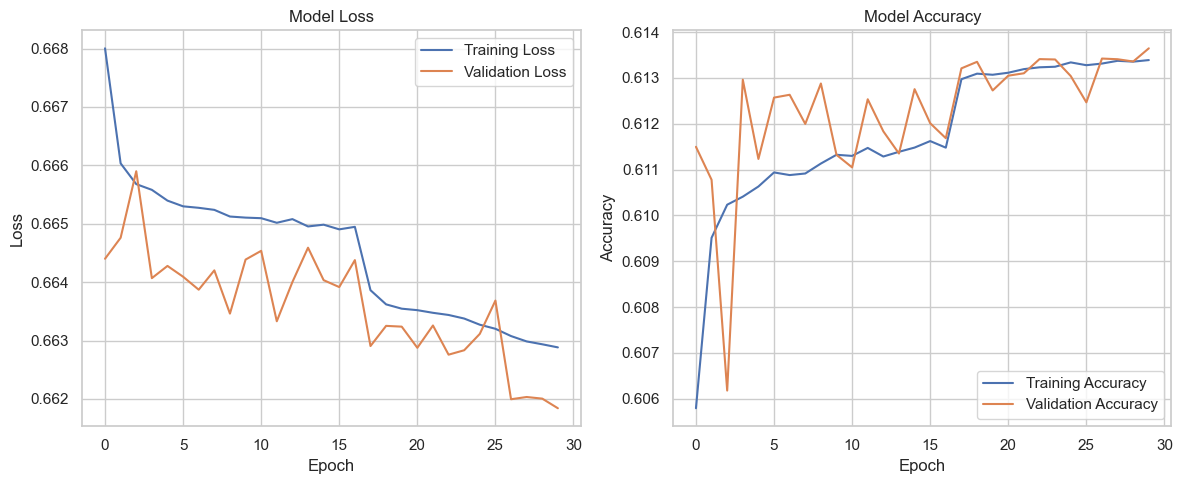

In [9]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

29064/29064 [==============================] - 43s 1ms/step - loss: 0.6623 - accuracy: 0.6131
Test Loss: 0.6623
Test Accuracy: 0.6131
29064/29064 [==============================] - 40s 1ms/step

Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.79      0.69    505457
        True       0.62      0.40      0.49    424562

    accuracy                           0.61    930019
   macro avg       0.61      0.60      0.59    930019
weighted avg       0.61      0.61      0.60    930019



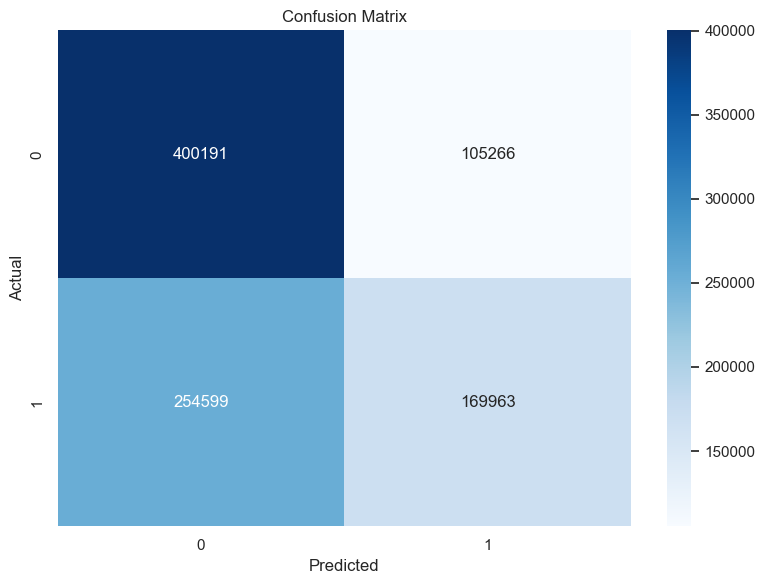

In [10]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Visualize Model Predictions

79/79 [==============================] - 0s 977us/step


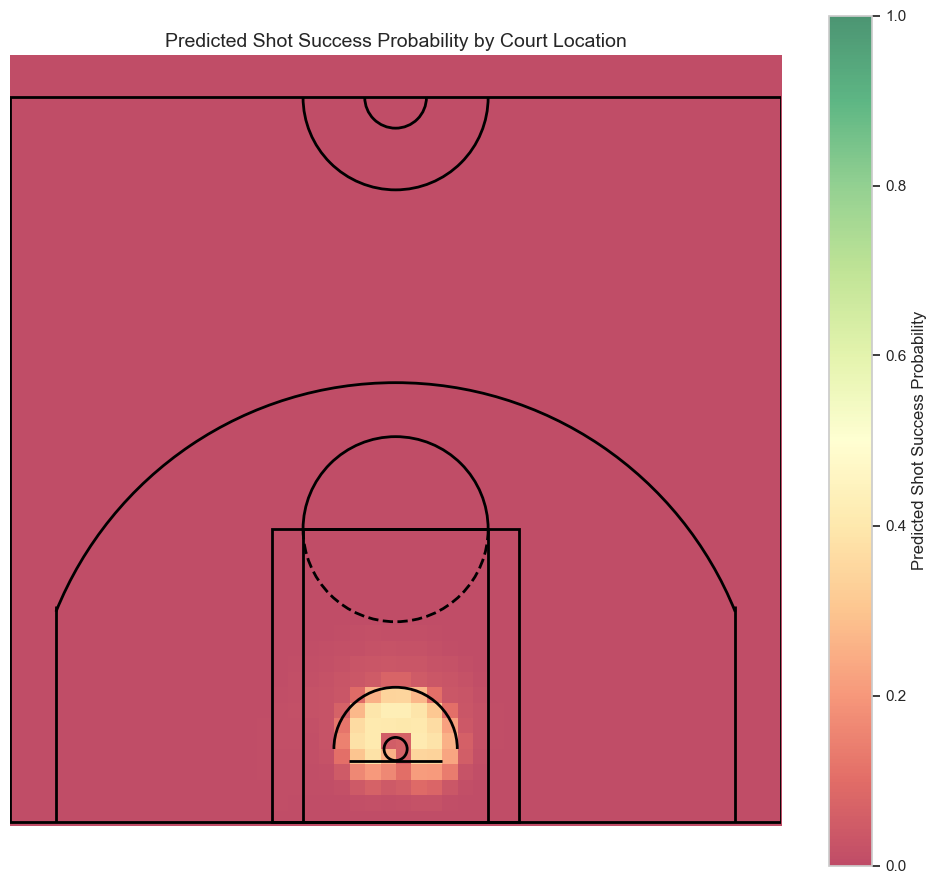

In [11]:
# Create a grid of court locations
grid_size = 50
x_min, x_max = -250, 250
y_min, y_max = -50, 450

x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Create input data for each grid point
grid_points = []
for i in range(grid_size):
    for j in range(grid_size):
        x = X_grid[i, j]
        y = Y_grid[i, j]
        distance = np.sqrt(x**2 + y**2)
        angle = np.arctan2(x, y) * 180 / np.pi
        grid_points.append([x, y, distance, angle])

grid_df = pd.DataFrame(grid_points, columns=spatial_features)
grid_norm = normalize_coordinates(grid_df)
grid_input = grid_norm[feature_cols].values

# Generate predictions for grid points
grid_pred = model.predict(grid_input).reshape(grid_size, grid_size)

# Plot prediction heatmap
plt.figure(figsize=(10, 9))
ax = plt.gca()
draw_court(ax, outer_lines=True)

# Plot heatmap
plt.imshow(grid_pred, origin='lower', extent=[x_min, x_max, y_min, y_max], 
           cmap='RdYlGn', vmin=0, vmax=1, alpha=0.7)
plt.colorbar(label='Predicted Shot Success Probability')

plt.title('Predicted Shot Success Probability by Court Location', fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.axis('off')
plt.tight_layout()
plt.show()

## Expected Points Analysis

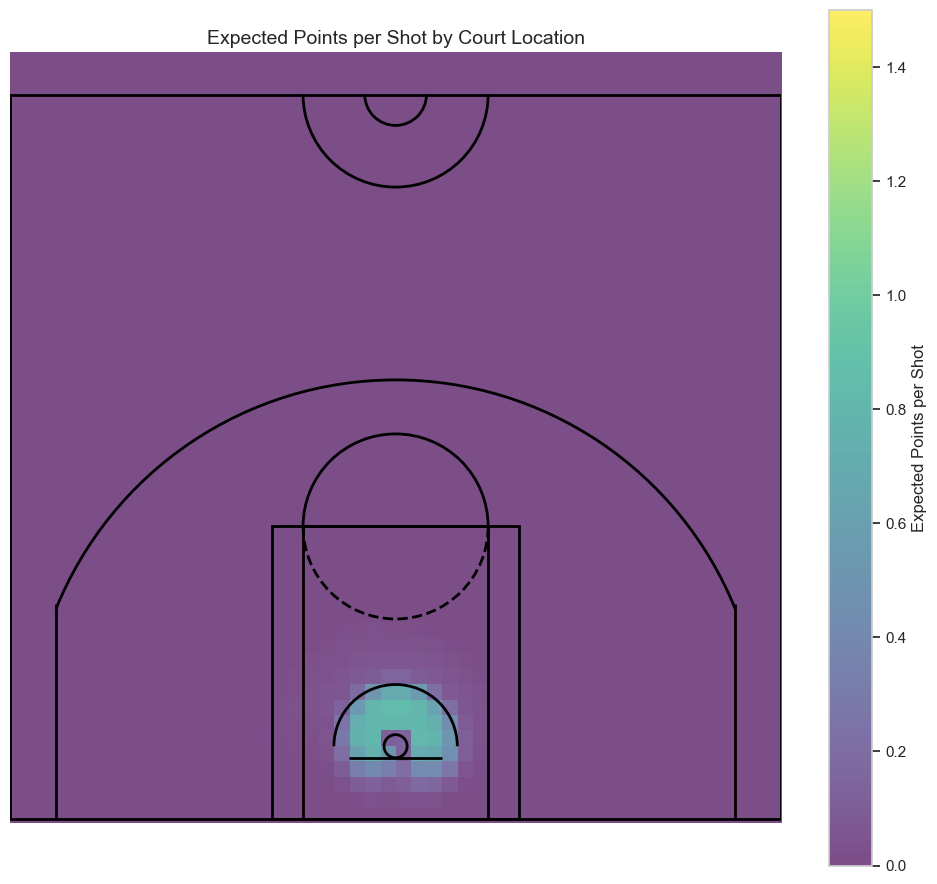

In [12]:
# Calculate expected points for each grid point
def calculate_expected_points(x, y, pred_prob):
    # Determine if shot is a 3-pointer
    distance_from_basket = np.sqrt(x**2 + y**2)
    is_corner_three = (abs(x) > 220) and (y < 140)
    is_three_pointer = (distance_from_basket > 237.5) or is_corner_three
    
    # Calculate expected points
    points = 3 if is_three_pointer else 2
    expected_points = points * pred_prob
    
    return expected_points, is_three_pointer

# Calculate expected points for grid
expected_points_grid = np.zeros((grid_size, grid_size))
shot_type_grid = np.zeros((grid_size, grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        x = X_grid[i, j]
        y = Y_grid[i, j]
        pred_prob = grid_pred[i, j]
        expected_points, is_three_pointer = calculate_expected_points(x, y, pred_prob)
        expected_points_grid[i, j] = expected_points
        shot_type_grid[i, j] = 3 if is_three_pointer else 2

# Plot expected points heatmap
plt.figure(figsize=(10, 9))
ax = plt.gca()
draw_court(ax, outer_lines=True)

# Plot heatmap
plt.imshow(expected_points_grid, origin='lower', extent=[x_min, x_max, y_min, y_max], 
           cmap='viridis', vmin=0, vmax=1.5, alpha=0.7)
plt.colorbar(label='Expected Points per Shot')

plt.title('Expected Points per Shot by Court Location', fontsize=14)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.axis('off')
plt.tight_layout()
plt.show()

## Distance and Angle Analysis

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_62616/2418368762.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_analysis = distance_success.groupby('distance_bin').agg(


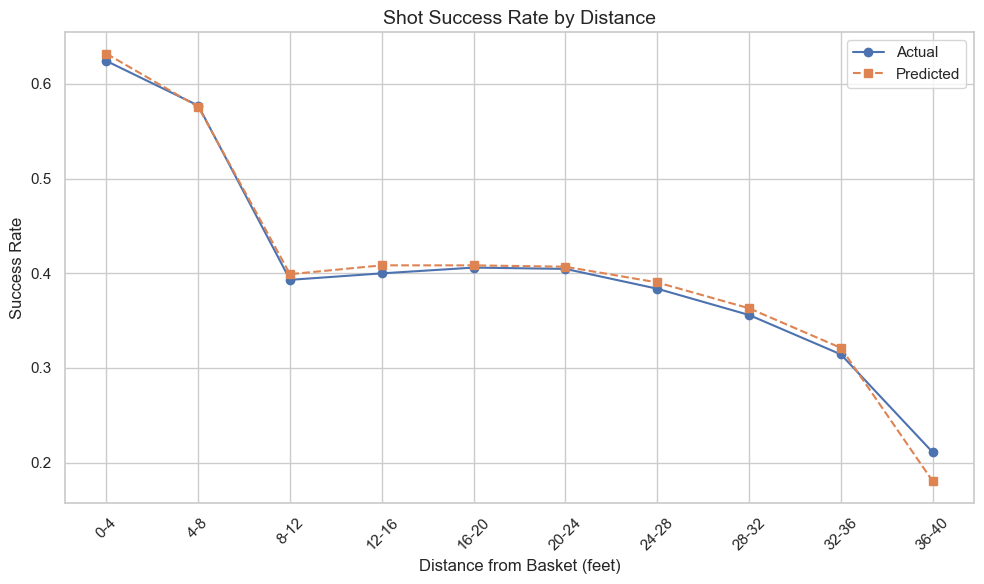

In [13]:
# Analyze shot success by distance
distance_bins = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
distance_labels = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24', '24-28', '28-32', '32-36', '36-40']
X_test['distance_bin'] = pd.cut(X_test['shot_distance'], bins=distance_bins, labels=distance_labels)

# Calculate actual success rate by distance
distance_success = pd.DataFrame({
    'distance_bin': X_test['distance_bin'],
    'actual': y_test,
    'predicted': y_pred_prob.flatten()
})

distance_analysis = distance_success.groupby('distance_bin').agg(
    actual_rate=('actual', 'mean'),
    predicted_rate=('predicted', 'mean'),
    count=('actual', 'count')
).reset_index()

# Plot distance analysis
plt.figure(figsize=(10, 6))
plt.plot(distance_analysis['distance_bin'], distance_analysis['actual_rate'], 'o-', label='Actual')
plt.plot(distance_analysis['distance_bin'], distance_analysis['predicted_rate'], 's--', label='Predicted')
plt.title('Shot Success Rate by Distance', fontsize=14)
plt.xlabel('Distance from Basket (feet)')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Save the Model

In [14]:
# Save model
model.save(spatial_model_dir / 'spatial_model_final.keras')
print(f"Model saved to {spatial_model_dir / 'spatial_model_final.keras'}")

Model saved to ../models/spatial_model/spatial_model_final.keras


## Key Insights

From our spatial modeling, we've discovered several key insights:

1. **Shot success probability decreases with distance** from the basket, with a sharp decline beyond 16 feet.

2. **Expected points analysis reveals optimal shooting locations**:
   - The restricted area (close to the basket) offers the highest expected points per shot
   - Corner three-pointers are more valuable than most mid-range shots despite being further from the basket
   - Mid-range shots (16-22 feet) generally offer the lowest expected points per shot

3. **Angle impacts shot success**, with straight-on shots generally having higher success rates than angled shots at the same distance.

4. **The model achieves good predictive performance** using only spatial features, demonstrating the importance of court location in shot success.

These insights can help teams optimize shot selection and defensive strategies. In the next notebook, we'll build a player embedding model to capture player-specific shooting patterns.